In [1]:
import numpy as np
import matplotlib.pylab as pl
import ot
import torch
import proplot as plot
import matplotlib.patches as patches
plot.rc['figure.facecolor'] = "white"

In [2]:
device = 'cpu'

In [3]:
def SWGG_smooth(X,Y,theta,s=1,std=0):
    n,dim=X.shape
    
    X_line=torch.matmul(X,theta)
    Y_line=torch.matmul(Y,theta)
    
    X_line_sort,u=torch.sort(X_line,axis=0)
    Y_line_sort,v=torch.sort(Y_line,axis=0)
    
    X_sort=X[u]
    Y_sort=Y[v]
    
    Z_line=(X_line_sort+Y_line_sort)/2
    Z=Z_line[:,None]*theta[None,:]
    
    W_XZ=torch.sum((X_sort-Z)**2)/n
    W_YZ=torch.sum((Y_sort-Z)**2)/n
    
    X_line_extend = X_line_sort.repeat_interleave(s,dim=0)
    X_line_extend_blur = X_line_extend + 0.5 * std * torch.randn(X_line_extend.shape)
    Y_line_extend = Y_line_sort.repeat_interleave(s,dim=0)
    Y_line_extend_blur = Y_line_extend + 0.5 * std * torch.randn(Y_line_extend.shape)
    
    X_line_extend_blur_sort,u_b=torch.sort(X_line_extend_blur,axis=0)
    Y_line_extend_blur_sort,v_b=torch.sort(Y_line_extend_blur,axis=0)

    
    X_extend=X_sort.repeat_interleave(s,dim=0)
    Y_extend=Y_sort.repeat_interleave(s,dim=0)
    X_sort_extend=X_extend[u_b]
    Y_sort_extend=Y_extend[v_b]
    
    bary_extend=(X_sort_extend+Y_sort_extend)/2
    bary_blur=torch.mean(bary_extend.reshape((n,s,dim)),dim=1)
    
    W_baryZ=torch.sum((bary_blur-Z)**2)/n
    return -4*W_baryZ+2*W_XZ+2*W_YZ,bary_blur

# Define the 2 distributions

In [18]:
n = 2  #nb samples
dim = 2 #dimension
 
xs=np.array([[-1,1],[2,-1]])
xt=np.array([[1,0.75],[-2,-0.5]])

X = torch.from_numpy(xs).to(device)
Y = torch.from_numpy(xt).to(device)
X=X.float()
Y=Y.float()


# Compute $W_2^2$, $SWGG_2^2$ and its smooth surrogate, for theta sampled regularly on the circle

In [19]:
Xs_torch = torch.from_numpy(xs).to(device).float()
Xt_torch = torch.from_numpy(xt).to(device).float()

num_proj=360
thetas = np.linspace(0, 2*np.pi, num_proj)
dire = np.array([(np.cos(theta),np.sin(theta)) for theta in thetas])
dir_torch=torch.from_numpy(dire).to(device)

proj = dir_torch.cpu().numpy()
true_ot = ot.emd2([],[],ot.dist(xs, xt))
swgg_theta = [SWGG_smooth(Xs_torch,Xt_torch, p.float(), 1, 0)[0] for p in dir_torch]
swgg_smooth_theta = [SWGG_smooth(Xs_torch,Xt_torch, p.float(), 10000, .8)[0] for p in dir_torch]
bary_theta = [SWGG_smooth(Xs_torch,Xt_torch, p.float(), 10000, .8)[1] for p in dir_torch]
w_theta = [true_ot for p in proj]


In [20]:
swgg_theta_thres = np.array(np.round(swgg_theta[:-1],2))-np.array(np.round(swgg_theta[1:],2))
lines = np.where(swgg_theta_thres!=0)[0]

bary_x_true = np.zeros((2,2))
bary_x_true[0] = (xs[0]+xt[0])/2
bary_x_true[1] = (xs[1]+xt[1])/2
bary_y_true = np.zeros((2,2))
bary_y_true[0] = (xs[0]+xt[1])/2
bary_y_true[1] = (xs[1]+xt[0])/2

bary_x_gen = np.zeros((len(bary_theta),2))
bary_y_gen = np.zeros((len(bary_theta),2))
for i in range(len(bary_theta)):
    bary_x_gen[i] = bary_theta[i][0]
    bary_y_gen[i] = bary_theta[i][1]

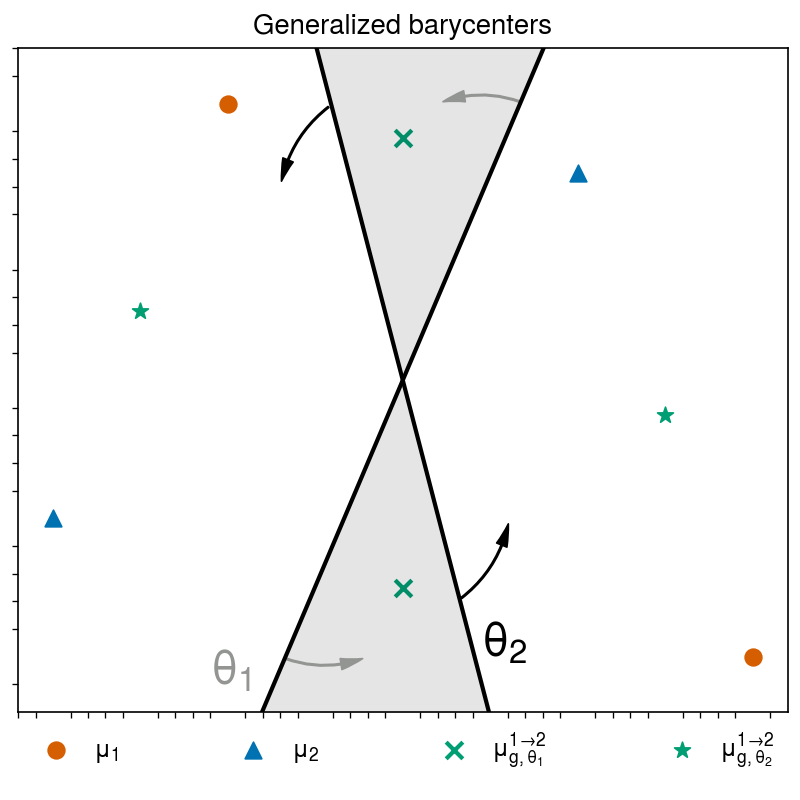

In [21]:
fig = plot.figure(share=False, figsize=(4,4))
#pl.rcParams.update({
#    "text.usetex": True,
#    "font.family": "sans-serif",
#    "font.sans-serif": "Helvetica",
#})
    
# Plot by passing both x and y coordinates
ax = fig.subplot(111, title='Generalized barycenters')

ax.scatter(xs[:,0], xs[:,1], marker = 'o', color='C1', alpha=1, label=r"$\mu_1$")
ax.scatter(xt[:,0], xt[:,1], marker='^',  color='C0', alpha=1, label=r"$\mu_2$")
ax.scatter(bary_x_true[:,0], bary_x_true[:,1], marker = 'x', color='C2', alpha=1,label=r"$\mu^{1 \to2}_{g, \theta_1}$")
ax.scatter(bary_y_true[:,0], bary_y_true[:,1], marker='*',  color='C2', alpha=1,label=r"$\mu^{1 \to2}_{g, \theta_2}$")

#draw lines corresponding to the different barycenters
ax.axline((0,0), (proj[lines[0]][0], proj[lines[0]][1]), c="k")
ax.axline((0,0), (proj[lines[1]][0], proj[lines[1]][1]), c="k")

ax.fill_between(x=[-0.5,0,0.8],y1=[1.2,0,1.2],y2=2,alpha=.1,color='k')
ax.fill_between(x=[-0.8,0,0.5],y1=[-1.2,0,-1.2],y2=-2,alpha=.1,color='k')

style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="gray")
a1 = patches.FancyArrowPatch((-0.7, -1), (-0.2, -1),connectionstyle="arc3,rad=.2", **kw)
a2 = patches.FancyArrowPatch((0.7, 1), (0.2, 1),connectionstyle="arc3,rad=.2", **kw)
ax.text(-1.1, -1.1, r"$\theta_1$", fontsize=17, c="gray")

style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")
a3 = patches.FancyArrowPatch((0.31, -0.8), (0.61, -0.5),connectionstyle="arc3,rad=.2", **kw)
a4 = patches.FancyArrowPatch((-0.4, 1), (-0.7, 0.7),connectionstyle="arc3,rad=.2", **kw)
ax.text(0.45, -1, r"$\theta_2$", fontsize=17)

for a in [a1, a2, a3, a4]:
    pl.gca().add_patch(a)

ax.grid(False)
pl.xlim(-2.2, 2.2)
pl.ylim(-1.2,1.2)
pl.legend(fontsize=27, bbox_to_anchor=(0, -0.01, 1, 0), loc="upper left", mode="expand", ncol=4, frameon=False)
pl.xlabel("")
pl.ylabel("")
ax.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)




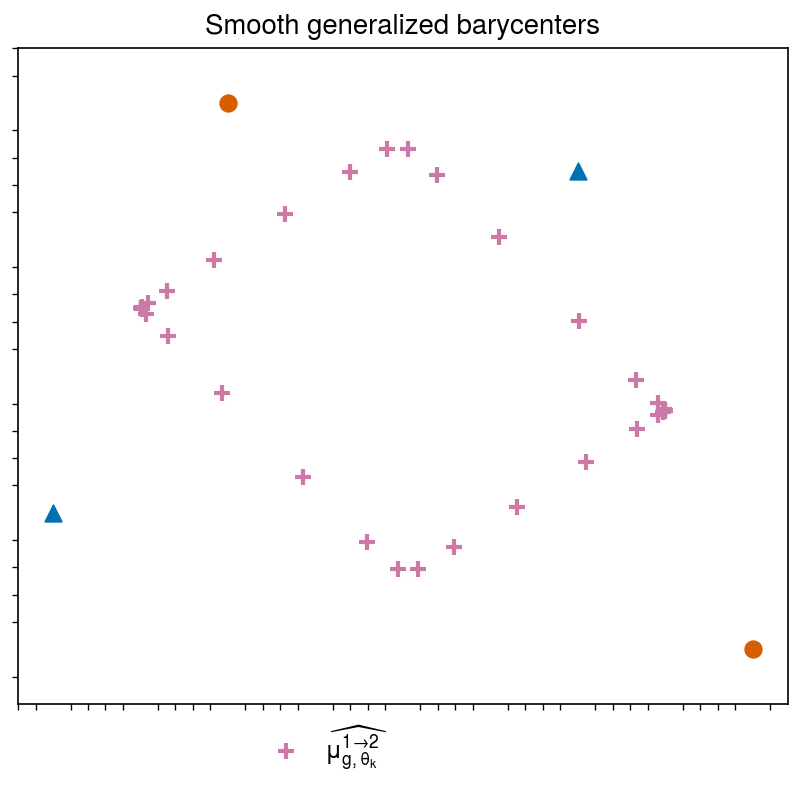

In [22]:
fig = plot.figure(share=False, figsize=(4,4))
#-----------------second plot
ax = fig.subplot(111, title='Smooth generalized barycenters')
ax.grid(False)

ax.scatter(xs[:,0], xs[:,1], marker = 'o', color='C1', alpha=1)
ax.scatter(xt[:,0], xt[:,1], marker='^',  color='C0', alpha=1)
ax.scatter(bary_x_gen[::10,0], bary_x_gen[::10,1], marker = '+', color='C3', alpha=1,label=r"$\widehat{\mu^{1 \to2}_{g, \theta_k}}$")


#pl.legend()
pl.grid(False)
pl.xlim(-2.2, 2.2)
pl.ylim(-1.2,1.2)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.legend(fontsize=14, bbox_to_anchor=(0.3, -0.01, 0.45, 0), loc="upper left", mode="expand", ncol=1, frameon=False)
#fig.format(xlabel='xlabel', ylabel='ylabel')

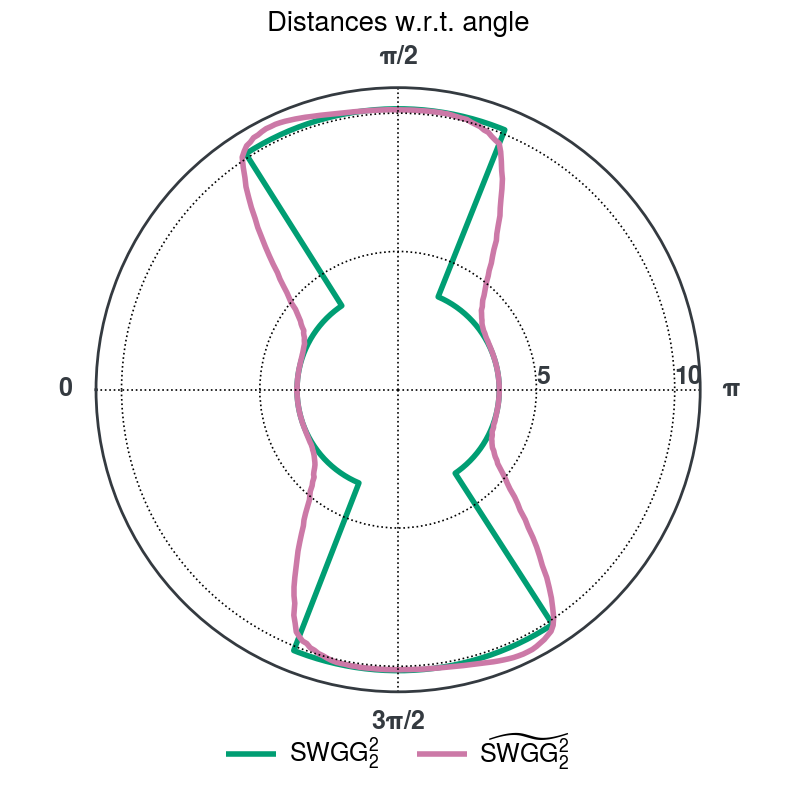

In [23]:
fig = plot.figure(share=False, figsize=(4,4))
#-----------------third plot
ax = fig.subplot(111, proj='polar', title='Distances w.r.t. angle')
ax.plot(thetas[: num_proj], swgg_theta[: num_proj], c='C2', zorder=0, lw=2,label=r'$SWGG^2_2$')
ax.plot(thetas[: num_proj], swgg_smooth_theta[: num_proj], zorder=0, lw=2,label=r'$\widetilde{SWGG}^2_2$',c='C3')


ax.format(suptitle='', linewidth=1,
           ticklabelsize=9, rlines=0.5)#, r0 = np.min(msw_theta_b)-5)
ax.format(thetaformatter='pi', rlines=5, gridalpha=1, gridlinestyle=':',rlabelpos=180, color='gray8', ticklabelweight='bold')
pl.legend(fontsize=9, bbox_to_anchor=(-0.2, -.2, 1.4, 0.2), loc="center", ncol=2, frameon=False)
ax.format(thetadir=-1, thetalines=90, thetalim=(0, 360), theta0='W',rlines=plot.arange(5, 30, 5))
#pl.savefig("polar.pdf",bbox_inches='tight')
